## Prior knowledge modelling approach

This Jupyter notebook script reproduce part of the results in the manuscript **"Advancing human displacement modelling: A case study of the 2022 summer floods in Pakistan"**, submitted to Earth's Future for peer-review.

This scrpt contains the code to reproduce the results of displacement estimation using the prior knowledge modelling approach, and compared to the reported displacement number from PDMA (2022) (methods described in the manuscript section 2.4.1). 

The script also produces the plot Figure 2a in the manuscript.

In [1]:
import os
from pathlib import Path
import fiona
import numpy as np
import geopandas as gdp
import pandas as pd
from rasterio.warp import Resampling
from rasterio.errors import RasterioIOError

from climada.entity import Exposures, ImpactFunc, ImpactFuncSet
from climada.hazard import Hazard
from climada.engine import ImpactCalc

/Users/kampu/opt/anaconda3/envs/climada_dev/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
HAZ_TYPE = 'FL'

SHP_DIR = '../data/boundaries/Sindh_admin2_delineated/'

ADMIN2_LIST = os.listdir(SHP_DIR)

SHP_FILE = SHP_DIR + '/{admin2_name}/{admin2_name_lowercase}.shp'

PAK_POP_FILE = '../data/population/pak_ppp_2020_UNadj_constrained.tif'

HAZ_FILE = '../data/flood_depth/Sindh/{admin2_name}_FloodDepth/{admin2_name_lowercase}_flooddepth1.tif'

DISPLACEMENT_DATA_PATH = Path("../data/displacement_data/PDMA_report_sep_17.xlsx")

ADMIN2_RENAME = {'KARACHI': 'Karachi',
                 'DADU': 'Dadu',
                 'BADIN': 'Badin',
                 'JAMSHORO': 'Jamshoro',
                 'LARKANA': 'Larkana',
                 'JACOBABAD': 'Jacobabad',
                 'KAMBER': 'Kambar Shahdad Kot',
                 'THATTA': 'Thatta',
                 'HYDERABAD': 'Hyderabad',
                 'KHAIPUR': 'Khairpur',
                 'SUKKUR': 'Sukkur',
                 'TANDO_ALLAHYAR': 'Tando Allahyar',
                 'GHOTKI': 'Ghotki',
                 'KASHMORE': 'Kashmore',
                 'SANGHAR': 'Sanghar',
                 'SUJAWAL': 'Sujawal',
                 'SBA': 'Shaheed Benazir Abad',
                 'THARPARKAR': 'Tharparkar',
                 'MATIARI': 'Matiari',
                 'N_FEROZE': 'Naushahro Feroze',
                 'TMK': 'Tando Muhammad Khan',
                 'SHIKAPUR': 'Shikarpur',
                 'MIRPURKAS': 'Mirpur Khas',
                 'UMERKOT': 'Umer Kot'
                }

impf_step_list = np.arange(.5,2.5,.5)

results_dic = {}

#### Load the reported displacement number

In [3]:
displacement_data = pd.read_excel(DISPLACEMENT_DATA_PATH)
displacement_data

,Khairpur,Larkana,Dadu,Umer Kot,Mirpur Khas,Kambar Shahdad Kot,Shaheed Benazir Abad,Sanghar,Kashmore,Jacobabad,...,Badin,Sujawal,Ghotki,Matiari,Hyderabad,Tando Allahyar,Sukkur,Tharparkar,Tando Muhammad Khan,Karachi
0,1218177,1071333,804271,557280,472168,390245,389529,315444,311262,256584,...,96073,95715,84339,51000,33700,27377,19500,19315,15500,508


In [4]:
# create the impact function
def create_step_impf(threshold=1.):
    impf_func = ImpactFunc.from_step_impf(intensity=(0,threshold, 100),
                                          haz_type=HAZ_TYPE)
    impf_func.name = 'No. of people displaced using step func'
    
    impf_set = ImpactFuncSet()
    impf_set.append(impf_func)
    
    return impf_set

#### Calculate the displacement number using different flood depth thresholds from 0.5-2.0 m

In [5]:
for admin2_name in ADMIN2_LIST:
    # read in the shapefile
    try:
        admin2_shp = gdp.read_file(SHP_FILE.format(admin2_name=admin2_name, admin2_name_lowercase=admin2_name.lower()))
    except fiona.errors.DriverError:
        print("fiona error")
        
    
    # read the population layers
    admin2_pop = Exposures.from_raster(PAK_POP_FILE, geometry=admin2_shp.geometry.values)
    admin2_pop.gdf['impf_FL'] = np.ones(len(admin2_pop.gdf))
    admin2_pop.value_unit = 'No. of People'
    
    # open haz file and reproject to the same window as exposures
    try:
        pak_flood_depth = Hazard.from_raster(HAZ_FILE.format(admin2_name=admin2_name, admin2_name_lowercase=admin2_name.lower()),
                                             haz_type=HAZ_TYPE,
                                             transform=admin2_pop.meta['transform'],
                                             height=admin2_pop.meta['height'],
                                             width=admin2_pop.meta['width'],
                                             resampling=Resampling.bilinear)
    except RasterioIOError:
         print("haz file is invalid:", admin2_name)
         continue
    
    # calculate the impact
    results_arr = np.zeros(len(impf_step_list))
    for idx, impf_step in enumerate(impf_step_list):
        
        impf_set = create_step_impf(impf_step)
        
        imp = ImpactCalc(admin2_pop, impf_set, pak_flood_depth).impact()
        
        results_arr[idx] = imp.aai_agg
        
    # store results in the dictionary
    adm2_rename = ADMIN2_RENAME[admin2_name]
    results_dic[adm2_rename] = results_arr

df_result = pd.DataFrame.from_dict(data=results_dic, orient='index', columns=['0.5m', '1.0m', '1.5m', '2.0m'])

fiona error
haz file is invalid: .DS_Store


#### Append the PDMA displacement number to the dataframe

In [6]:
pdma_no = np.zeros(len(df_result))

for idx, admin_name in enumerate(df_result.index):
    pdma_no[idx] = displacement_data[admin_name]

df_result['PDMA_displaced'] = pdma_no

/var/folders/41/j3k_03px3_q_s_sg40230ksw0000gq/T/ipykernel_74328/1450086818.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pdma_no[idx] = displacement_data[admin_name]


#### Plot the Figure 2a

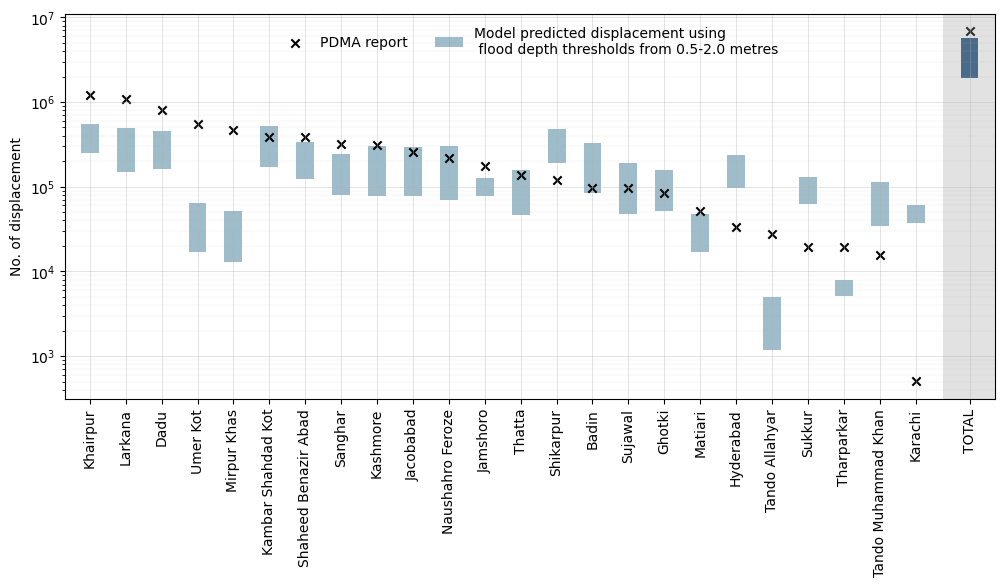

In [7]:
import matplotlib.pyplot as plt

df_result.sort_values(by='PDMA_displaced', ascending=False, inplace=True)

bar_width=0.5
color_list = ['#7EB1BC', '#6090A7', '#486B8B', '#334769']
alpha_list = [.4, .6, .8, .8]

fig = plt.figure(figsize=(12,5))
plt.grid(visible=True, lw=.5, alpha=.5)
plt.grid(which='minor', axis='y',
         lw=.3, alpha=.3)

# plot the range of the step function prediction
plt.bar(np.arange(len(df_result)), 
        height=df_result['0.5m']-df_result['2.0m'],
        bottom=df_result['2.0m'],
        width=bar_width,
        color='#6090A7',
        alpha=0.6,
        label='Model predicted displacement using\n flood depth thresholds from 0.5-2.0 metres')


# plot the reported number
plt.scatter(np.arange(len(df_result)),
            df_result['PDMA_displaced'],
            color='k',
            marker='x',
            label='PDMA report')


    
### plot the total value as well
plt.axvspan(23.75, 25.2, color='lightgrey', alpha=0.65, lw=0)
plt.bar(24.5,
        height=df_result['0.5m'].sum()-df_result['2.0m'].sum(),
        bottom=df_result['2.0m'].sum(),
        width=bar_width,
        color='#486B8B')

plt.scatter(24.5,
            df_result['PDMA_displaced'].sum(),
            color='k',
            marker='x',
            alpha=.8)
    
#plt.ylim([0, 1000])
plt.yscale("log")
plt.xlim([-0.7, 25.2])
plt.ylabel('No. of displacement')
plt.xticks(np.append(np.arange(len(df_result)), [24.5]), 
           labels=np.append(df_result.index.to_numpy(), ['TOTAL']), rotation=90)
#plt.hlines(100, -0.7, 24.7, linestyle='--', lw=.7, color='k')
plt.legend(ncol=2, frameon=False, loc='upper center')

# fig.savefig('./step_func_imp_plot.png')